In [2]:
import torch
import ase
import numpy as np
import scipy
from ase.build import molecule, bulk, make_supercell
from ase.neighborlist import neighbor_list
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
from torch_nl import compute_neighborlist, compute_neighborlist_n2, ase2data
from torch_nl.timer import timeit

# Periodic systems

##  Metal 

In [4]:
frame = bulk('Si', 'diamond', a=4, cubic=True)
aa = torch.arange(1, 4)
Ps = torch.cartesian_prod(aa,aa,aa)
Ps = Ps[torch.sort(Ps.sum(dim=1)).indices].to(torch.long).numpy()
frames = []
n_atoms = []
for P in Ps:
    frames.append(make_supercell(frame, np.diag(P)))
    n_atoms.append(len(frames[-1]))
n_atoms = np.array(n_atoms)

In [5]:
cutoff = 4

In [6]:
tag = "ASE"
datas = []
for frame in tqdm(frames):
    timing = timeit(neighbor_list, ['ijS', frame, cutoff], tag=tag, warmup=1, nit=50)
    data = timing.dumps()
    i,j,S = neighbor_list('ijS', frame, cutoff)
    n_neighbor = np.bincount(i).mean()
    data.update(n_atom=len(frame), n_neighbor_per_atom_avg=int(n_neighbor))
    data.pop('samples')
    datas.append(data)
# df = pd.DataFrame(datas)

  0%|          | 0/27 [00:00<?, ?it/s]

In [7]:
tags = [
    # "torch_nl O(n^2) CPU", 
    # "torch_nl O(n^2) GPU", 
    "torch_nl O(n) CPU", 
    # "torch_nl O(n) GPU"
]
for tag in tqdm(tags):
    if "CPU" in tag:
        device = 'cpu'
    elif "GPU" in tag:
        device = 'cuda'
        
    if 'O(n^2)' in tag:
        nl_func = compute_neighborlist_n2
    elif 'O(n)' in tag:
        nl_func = compute_neighborlist

    for frame in tqdm(frames):
        pos, cell, pbc, batch, n_atoms = ase2data([frame], device=device)
        timing = timeit(nl_func, [cutoff, pos, cell, pbc, batch], tag=tag, warmup=10, nit=50)
        data = timing.dumps()
        data.pop('samples')
        mapping, mapping_batch, shifts_idx = nl_func(cutoff, pos, cell, pbc, batch)
        n_neighbor = np.bincount(mapping[0].cpu().numpy()).mean()
        data.update(n_atom=len(frame), n_neighbor_per_atom_avg=int(n_neighbor))
        datas.append(data)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame(datas)

In [9]:
df

,tag,mean,stdev,min,max,n_atom,n_neighbor_per_atom_avg
0,ASE,0.002439,0.000027,0.002380,0.002541,8,28
1,ASE,0.003136,0.000131,0.003051,0.003652,16,28
2,ASE,0.003092,0.000048,0.003052,0.003271,16,28
3,ASE,0.003084,0.000062,0.003053,0.003487,16,28
4,ASE,0.002837,0.000034,0.002803,0.002966,24,28
5,ASE,0.004419,0.000118,0.004324,0.005133,32,28
6,ASE,0.002838,0.000062,0.002805,0.003203,24,28
7,ASE,0.002823,0.000026,0.002797,0.002942,24,28
8,ASE,0.004364,0.000048,0.004330,0.004574,32,28
9,ASE,0.004365,0.000056,0.004331,0.004600,32,28


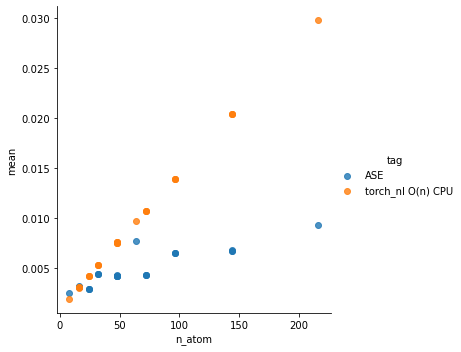

In [10]:
sns.lmplot(data=df, x='n_atom', y='mean', hue='tag',fit_reg=False)

In [212]:
frames = [molecule('OCHCHO'), molecule('C3H9C')]
# frames = [molecule('C3H9C')]
frames += [bulk('Si', 'diamond', a=6, cubic=True)]
frames += [bulk('Si', 'diamond', a=4, cubic=True)]
# frames = [bulk('Si', 'diamond', a=6.1, cubic=True)]
rcut = 3

# pos = torch.from_numpy(frame.get_positions())
# cell = torch.from_numpy(frame.get_cell().array)
# pbc = torch.from_numpy(frame.get_pbc())
n_atoms = [0]
pos = []
cell = []
pbc = []
for ff in frames:
    n_atoms.append(len(ff))
    pos.append(torch.from_numpy(ff.get_positions()))
    cell.append(torch.from_numpy(ff.get_cell().array))
    pbc.append(torch.from_numpy(ff.get_pbc()))
pos = torch.cat(pos)
cell = torch.cat(cell)
pbc = torch.cat(pbc)
stride = torch.from_numpy(np.cumsum(n_atoms))
batch = torch.zeros(pos.shape[0],dtype=torch.long)
for ii,(st,nd) in enumerate(zip(stride[:-1],stride[1:])):
    batch[st:nd] = ii
n_atoms = torch.Tensor(n_atoms[1:]).to(dtype=torch.long)
batch,n_atoms, pos.shape, cell.shape, pbc.shape

(tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([ 6, 13,  8,  8]),
 torch.Size([35, 3]),
 torch.Size([12, 3]),
 torch.Size([12]))

In [213]:
dist = []
mm = []
for frame in frames:
    idx_i, idx_j, idx_S, dd = neighbor_list(
            "ijSd", frame, cutoff=rcut, self_interaction=False
        )
    dist.append(np.sort(dd))
    mm.append((idx_i, idx_j))

In [219]:
def get_fully_connected_mapping(i_ids, shifts_idx) -> torch.Tensor:
    n_atom = i_ids.shape[0]
    n_atom2 = n_atom * n_atom
    n_cell_image = shifts_idx.shape[0]
    j_ids = torch.repeat_interleave(i_ids, n_cell_image)
    mapping = torch.cartesian_prod(i_ids, j_ids)
    shifts_idx = shifts_idx.repeat((n_atom2, 1))
    
    mask = torch.ones(mapping.shape[0], dtype=bool, device=i_ids.device)
    ids = n_cell_image*torch.arange(n_atom, device=i_ids.device) \
                + torch.arange(0, mapping.shape[0], n_atom*n_cell_image, device=i_ids.device)
    # print(n_atom*n_cell_image, ids)
    mask[ids] = False
    mapping = mapping[mask, :]
    shifts_idx = shifts_idx[mask]
    return mapping, shifts_idx

def compute_images(
    positions: torch.Tensor,
    cell: torch.Tensor,
    pbc: torch.Tensor,
    cutoff: float,
    batch: torch.Tensor,
    n_atoms: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """TODO: add doc"""
    cell = cell.view((-1, 3, 3)).to(torch.float32)
    pbc = pbc.view((-1, 3))
    dtype = cell.dtype
    has_pbc = pbc.prod(dim=1, dtype=bool)
    stride = torch.zeros(n_atoms.shape[0]+1,dtype=torch.long)
    stride[1:] = torch.cumsum(n_atoms, dim=0,dtype=torch.long)
    reciprocal_cell = torch.zeros_like(cell)
    reciprocal_cell[has_pbc,:,:] = torch.linalg.inv(cell[has_pbc,:,:]).transpose(2, 1)
    inv_distances = reciprocal_cell.norm(2, dim=-1)
    num_repeats = torch.ceil(cutoff * inv_distances).to(torch.long)
    num_repeats_ = torch.where(pbc, num_repeats, torch.zeros_like(num_repeats))
    ids = torch.arange(positions.shape[0], device=positions.device, dtype=torch.long)
    images, mapping, batch_mapping, shifts_expanded, shifts_idx_ = [], [], [], [], []
    for i_structure in range(n_atoms.shape[0]):
        num_repeats = num_repeats_[i_structure]
        reps = []
        for ii in range(3):
            r1 = torch.arange(
                -num_repeats[ii],
                num_repeats[ii] + 1,
                device=cell.device,
                dtype=dtype,
            )
            _, indices = torch.sort(torch.abs(r1))
            reps.append(r1[indices])
        shifts_idx = torch.cartesian_prod(*reps)
        n_cell_image = shifts_idx.shape[0]
        n_atom = n_atoms[i_structure]
        pos = positions[stride[i_structure]:stride[i_structure+1]]
        i_ids = ids[stride[i_structure]:stride[i_structure+1]]
        
        s_mapping, shifts_idx = get_fully_connected_mapping(i_ids, shifts_idx)
        mapping.append(s_mapping)
        batch_mapping.append(
            i_structure
            * torch.ones(
                s_mapping.shape[0], dtype=torch.long, device=cell.device
            )
        )
        shifts_idx_.append(shifts_idx)
    return (
        torch.cat(mapping, dim=0).t(),
        torch.cat(batch_mapping, dim=0),
        torch.cat(shifts_idx_, dim=0),
    )

In [221]:
from typing import Optional
def compute_distances(
    pos: torch.Tensor,
    mapping: torch.Tensor,
    cell_shifts: Optional[torch.Tensor] = None,
):
    assert mapping.dim() == 2
    assert mapping.shape[0] == 2

    if cell_shifts is None:
        dr = pos[mapping[1]] - pos[mapping[0]]
    else:
        dr = pos[mapping[1]] - pos[mapping[0]] + cell_shifts

    return dr.norm(p=2, dim=1)

def compute_cell_shifts(cell, shifts_idx, batch_mapping):
    if cell is None:
        cell_shifts = None
    else:
        cell_shifts = torch.einsum("jn,jnm->jm", shifts_idx, cell.view(-1, 3, 3)[batch_mapping])
    return cell_shifts

def compute_strict_nl_n2(pos, cell, mapping, batch_mapping,  shifts_idx):
    cell_shifts = compute_cell_shifts(cell, shifts_idx, batch_mapping)
    d2 = (pos[mapping[0]] - pos[mapping[1]] - cell_shifts).square().sum(dim=1)
    mask = d2 <= rcut*rcut
    mapping = mapping[:, mask]
    mapping_batch = batch_mapping[mask]
    shifts_idx = shifts_idx[mask]
    return mapping, mapping_batch, shifts_idx # , d2[mask].sqrt()

def compute_nl(pos, cell, pbc, rcut, batch, method='n2'):
    n_atoms = torch.bincount(batch)
    mapping, batch_mapping, shifts_idx = compute_images(pos, 
                                     cell, pbc, rcut, 
                                     batch, 
                                     n_atoms)
    if method == 'n2':
        mapping, mapping_batch, shifts_idx = compute_strict_nl_n2(pos, cell, mapping, batch_mapping,  shifts_idx)
    
    return mapping, mapping_batch, shifts_idx

In [222]:
mapping, batch_mapping, shifts_idx = compute_images(pos, 
                                     cell, pbc, rcut, 
                                     batch, 
                                     n_atoms)

cell_shifts = compute_cell_shifts(cell, shifts_idx, batch_mapping)
d2 = (pos[mapping[0]] - pos[mapping[1]] - cell_shifts ).square().sum(dim=1)
mask = d2 <= rcut*rcut
d = d2[mask].sqrt()
mapping = mapping[:, mask]
mapping_batch = batch_mapping[mask]
d.shape

RuntimeError: expected scalar type Float but found Double

In [216]:
dist[0].shape,dist[0]

((26,),
 array([1.10563938, 1.10563938, 1.10563938, 1.10563938, 1.22295086,
        1.22295086, 1.22295086, 1.22295086, 1.51286   , 1.51286   ,
        2.05241169, 2.05241169, 2.05241169, 2.05241169, 2.22229623,
        2.22229623, 2.22229623, 2.22229623, 2.38769877, 2.38769877,
        2.38769877, 2.38769877, 2.61851372, 2.61851372, 2.61851372,
        2.61851372]))

In [217]:
images.shape, pos.shape, mapping.shape, shifts_expanded.shape, shifts_idx.shape

(torch.Size([216, 3]),
 torch.Size([35, 3]),
 torch.Size([2, 288]),
 torch.Size([216, 3]),
 torch.Size([3626, 3]))

In [218]:
for ii, dd in enumerate(dist):
    print(np.allclose(np.sort(dd), np.sort(d[mapping_batch == ii].numpy())))

True
True
True
True


In [12]:
d2.min(), rcut*rcut

(tensor(1.1977, dtype=torch.float64), 9)

In [35]:
dist[0].shape, d.shape, d2.shape

((32,), torch.Size([23]), torch.Size([1720]))

In [36]:
mapping.shape, images.shape, mapping

(torch.Size([2, 23]),
 torch.Size([216, 3]),
 tensor([[ 0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,
           6,  7,  7,  7,  7],
         [ 1,  0,  2,  4,  6,  1,  3,  2, 14, 28, 32,  1,  5,  4, 14, 74, 80,  1,
           7,  6, 28, 74, 96]]))

In [27]:
aa = torch.arange(3).reshape(3,1)
torch.cat([aa,aa], dim=1)

tensor([[0, 0],
        [1, 1],
        [2, 2]])

In [22]:
torch.arange?

In [75]:
mapping

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3,
         5, 0, 1, 2, 3, 4]])

# linked cell 

In [348]:
from torch_nl import (compute_nl_n2, strict_nl, compute_distances, compute_cell_shifts, 
                      compute_images, ase2data)

In [349]:
from torch_nl.image import get_number_of_cell_repeats, get_cell_shift_idx

In [350]:
def get_stride(v):
    v = v.flatten()
    stride = v.new_empty(v.shape[0]+1)
    stride[0] = 0
    stride[1:] = torch.cumsum(v, dim=0, dtype=stride.dtype)
    return stride

In [447]:
frames = [molecule('OCHCHO'), molecule('C3H9C')]
frames = [molecule('C3H9C')]
frames += [bulk('Si', 'diamond', a=4, cubic=False)]
frames += [bulk('Si', 'diamond', a=4, cubic=True)]
frames += [
    bulk('Si', 'diamond', a=6.1, cubic=True), 
    bulk('Si', 'diamond', a=3.1, cubic=True)
]
rcut = 3
self_interaction = False
pos, cell, pbc, batch, n_atoms = ase2data(frames)

In [448]:
mapping, batch_mapping, shifts_idx = compute_images(
    pos, cell, pbc, rcut, n_atoms, self_interaction
)
mapping_r, batch_mapping_r, shifts_idx_r = strict_nl(
    rcut, pos, cell, mapping, batch_mapping, shifts_idx
)
cell_shifts_r = compute_cell_shifts(cell, shifts_idx_r, batch_mapping_r)
d_r = compute_distances(pos, mapping_r, cell_shifts_r).numpy()
d_r = np.sort(d_r)
d_r.shape,d_r

((518,),
 array([1.09439479, 1.09439479, 1.09439479, 1.09439479, 1.09439488,
        1.09439488, 1.09439488, 1.09439488, 1.09439498, 1.09439498,
        1.09439498, 1.09439498, 1.10242263, 1.10242263, 1.10242288,
        1.10242288, 1.10242288, 1.10242288, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.49342443, 1.49342443, 1.49342443, 1.49342443, 1.4934251 ,
        1.4934251 , 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205

In [449]:
def ravel_3d(idx_3d, shape):
    idx_linear = (idx_3d[:, 2] + shape[2] * (idx_3d[:, 1] + shape[1] * idx_3d[:, 0]))
    return idx_linear

def unravel_3d(idx_linear, shape):
    idx_3d = idx_linear.new_empty((idx_linear.shape[0], 3))
    idx_3d[:, 2] = torch.remainder(idx_linear, shape[2]) 
    idx_3d[:, 1] = torch.remainder(torch.div(idx_linear, shape[2], rounding_mode="floor"), shape[1])
    idx_3d[:, 0] = torch.div(idx_linear, shape[1]*shape[2], rounding_mode="floor") 
    return idx_3d


def get_linear_bin_idx(cell, pos, nbins_s):
    scaled_pos = torch.linalg.solve(cell.t(), pos.t()).t()
    bin_index_s = torch.floor(scaled_pos * nbins_s).to(torch.long)
    bin_index_l = ravel_3d(bin_index_s, nbins_s)
    return bin_index_l

def linked_cell(pos, cell, pbc, rcut, n_atoms, self_interaction=True):
    n_structure = n_atoms.shape[0]
    device = pos.device
    dtype = pos.dtype
    cell = cell.view((-1, 3, 3))
    pbc = pbc.view((-1, 3))
    
    num_repeats_ = get_number_of_cell_repeats(rcut, cell, pbc)

    stride = get_stride(n_atoms)
    ids = torch.arange(pos.shape[0], device=device, dtype=torch.long)

    mapping, batch_mapping, cell_shifts_idx = [], [], []
    for i_structure in range(n_structure):
        num_repeats = num_repeats_[i_structure]
        n_atom = n_atoms[i_structure]
        shifts_idx = get_cell_shift_idx(num_repeats, device, dtype)
        n_cell_image = shifts_idx.shape[0]
        shifts_idx = torch.repeat_interleave(shifts_idx, n_atom, dim=0)
        i_ids = ids[stride[i_structure] : stride[i_structure + 1]]
        i_pos = pos[i_ids]
        
        i_ids = i_ids.repeat(n_cell_image)
        batch_image = torch.zeros((shifts_idx.shape[0]), dtype=torch.long)
        cell_shifts = compute_cell_shifts(cell[i_structure], shifts_idx, batch_image)
        images = pos[i_ids] + cell_shifts
        
        i_min = images.min(dim=0).values
        images -= i_min - 1e-5
        i_pos -= i_min - 1e-5
        
        box_length = images.max(dim=0).values - images.min(dim=0).values + 1e-3
        nbins_s = torch.maximum(torch.ceil(box_length / rcut), pos.new_ones(3)).to(torch.long)
        nbins = torch.prod(nbins_s)
        box_vec = torch.diag_embed(box_length)
        bin_index_i = get_linear_bin_idx(box_vec, i_pos, nbins_s)
        bin_index_j = get_linear_bin_idx(box_vec, images, nbins_s)
        sb_idx_i, atom_i = torch.sort(bin_index_i)
        sb_idx_j, atom_j = torch.sort(bin_index_j)
        n_atom_i_per_bin = torch.bincount(bin_index_i)
        n_atom_j_per_bin = torch.bincount(sb_idx_j)
        s_atom_j_bin_stride = get_stride(n_atom_j_per_bin)
        s_atom_i_bin_stride = get_stride(n_atom_i_per_bin)
        
        i_bins_l = torch.unique(bin_index_i)
        i_bins_s = unravel_3d(i_bins_l, nbins_s)
        dd = torch.tensor([0,1,-1], dtype=torch.long)
        bin_shifts = torch.cartesian_prod(dd,dd,dd).repeat((i_bins_s.shape[0], 1))
        neigh_bins_s = (torch.repeat_interleave(i_bins_s, 27, dim=0) + bin_shifts)
        neigh_bins_l = ravel_3d(neigh_bins_s, nbins_s)
        mask = torch.logical_and(neigh_bins_l>=0, neigh_bins_l<nbins)
        neigh_i_bins_l = torch.repeat_interleave(i_bins_l, 27, dim=0)[mask]
        neigh_j_bins_l = neigh_bins_l[mask]
        neigh_bins_l = torch.cat([neigh_i_bins_l.view(1,-1), neigh_j_bins_l.view(1,-1)], dim=0)
        neigh_bins_l = torch.unique(neigh_bins_l, dim=1)
        neigh_atom = []
        for ii in range(neigh_bins_l.shape[1]):
            i_bin, j_bin = neigh_bins_l[:,ii]
            st,nd = s_atom_i_bin_stride[i_bin], s_atom_i_bin_stride[i_bin+1]
            i_atoms = atom_i[st:nd]
            
            st,nd = s_atom_j_bin_stride[j_bin], s_atom_j_bin_stride[j_bin+1]
            j_atoms = atom_j[st:nd]
            neigh_atom.append(torch.cartesian_prod(i_atoms, j_atoms).t())
            
        neigh_atom = torch.cat(neigh_atom, dim=1)
        if not self_interaction:
            neigh_atom = neigh_atom[:, neigh_atom[0]!=neigh_atom[1]]
        sorted_ids = torch.argsort(neigh_atom[0])
        neigh_atom = neigh_atom[:, sorted_ids]
        
        neigh_shift_idx = shifts_idx[neigh_atom[1]]
        neigh_atom[1] = torch.remainder(neigh_atom[1], n_atom)
        mapping.append(neigh_atom + stride[i_structure])
        batch_mapping.append(
            i_structure
            * torch.ones(neigh_atom.shape[1], dtype=torch.long, device=device)
        )
        cell_shifts_idx.append(neigh_shift_idx)
    return (
        torch.cat(mapping, dim=0),
        torch.cat(batch_mapping, dim=0),
        torch.cat(cell_shifts_idx, dim=0),
    )
mapping, batch_mapping, shifts_idx = linked_cell(pos, cell, pbc, rcut, n_atoms)
mapping.shape, shifts_idx.shape,batch_mapping.shape

mapping[:,25:50]

shifts_idx tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
i_ids tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
n_cell_image 1 torch.Size([13]) torch.Size([13, 3]) tensor(13)
torch.Size([13, 3]) tensor([2.1286, 1.9458, 0.4176], dtype=torch.float64) tensor([-2.1286, -1.7411, -1.0938], dtype=torch.float64)
torch.Size([13, 3]) tensor([2.1286, 1.9458, 0.4176], dtype=torch.float64) tensor([-2.1286, -1.7411, -1.0938], dtype=torch.float64)
box_length tensor([4.2582, 3.6879, 1.5124], dtype=torch.float64) tensor([2, 2, 1]) tensor(4)
tensor([[4.2582, 0.0000, 0.0000],
        [0.0000, 3.6879, 0.0000],
        [0.0000, 0.0000, 1.5124]], dtype=torch.float64)
bin_index_i tensor([0, 1, 2, 0, 1, 1, 3, 2, 2, 2, 0, 0, 0])
bin_index_j 

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 156 but got size 168 for tensor number 1 in the list.

In [452]:
torch.bincount?

[autoreload of torch_nl.neighbor_list failed: Traceback (most recent call last):
  File "/local_scratch/musil/miniconda/envs/cg39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/local_scratch/musil/miniconda/envs/cg39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/local_scratch/musil/miniconda/envs/cg39/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/musil/git/torch_nl/torch_nl/neighbor_list.py", line 4, in <module>
    from .naive_impl import build_naive_neighborhood
  File "/home/musil/git/torch_nl/torch_nl/naive_impl.py", line 4, in <module>
    from .ut

In [450]:
mapping, batch_mapping, shifts_idx = strict_nl(rcut, pos, cell, mapping, batch_mapping, shifts_idx)
cell_shifts = compute_cell_shifts(cell.view(-1,3,3), shifts_idx, batch_mapping)
d = compute_distances(pos, mapping, cell_shifts).numpy()
d = np.sort(d)
d.shape,d

((518,),
 array([1.09439479, 1.09439479, 1.09439479, 1.09439479, 1.09439488,
        1.09439488, 1.09439488, 1.09439488, 1.09439498, 1.09439498,
        1.09439498, 1.09439498, 1.10242263, 1.10242263, 1.10242288,
        1.10242288, 1.10242288, 1.10242288, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.34233938, 1.34233938, 1.34233938, 1.34233938, 1.34233938,
        1.49342443, 1.49342443, 1.49342443, 1.49342443, 1.4934251 ,
        1.4934251 , 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205081, 1.73205081, 1.73205081,
        1.73205081, 1.73205081, 1.73205

In [451]:
np.allclose(d, d_r)

True

In [380]:
aa = torch.tensor([[1,4,2,1], [3,8,5,8]])
torch.sort(aa, dim=1).values

tensor([[1, 1, 2, 4],
        [3, 5, 8, 8]])

In [403]:
aa = torch.tensor([0, 1]) 
bb = torch.tensor([], dtype=torch.int64)
torch.cartesian_prod(aa,bb)

tensor([], size=(0, 2), dtype=torch.int64)

In [408]:
aa.abs()

tensor([0, 1])

In [454]:
def fff(cell, rc):
    b1_c, b2_c, b3_c = np.linalg.pinv(cell).T

    # Compute distances of cell faces.
    l1 = np.linalg.norm(b1_c)
    l2 = np.linalg.norm(b2_c)
    l3 = np.linalg.norm(b3_c)
    face_dist_c = np.array([1 / l1 if l1 > 0 else 1,
                            1 / l2 if l2 > 0 else 1,
                            1 / l3 if l3 > 0 else 1])
    nbins_c = np.maximum((face_dist_c / rc).astype(int), [1, 1, 1])
    return nbins_c
cell = np.array([[6.19330899, 0.0, 0.0], [2.4074486111396207, 6.149627748674982, 0.0], [0.2117993724186579, 1.0208820183960539, 7.305899571570074]])


fff(cell, 5)

array([1, 1, 1])